In [1]:
from numpy import ndarray, log
from pandas import read_csv, DataFrame, Series, concat, get_dummies
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap, pairplot

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.pyplot import figure, savefig, show, subplots

from sklearn.preprocessing import OneHotEncoder

from dslab_functions import plot_multiline_chart, plot_multi_scatters_chart, plot_bar_chart, plot_multibar_chart, set_chart_labels, get_variable_types, define_grid, HEIGHT, encode_cyclic_variables, dummify

# read file
filename = "class_credit_score.csv"
file_tag = "class_credit_score"
df : DataFrame = read_csv('class_credit_score.csv')

#df

## Data Dimensionality

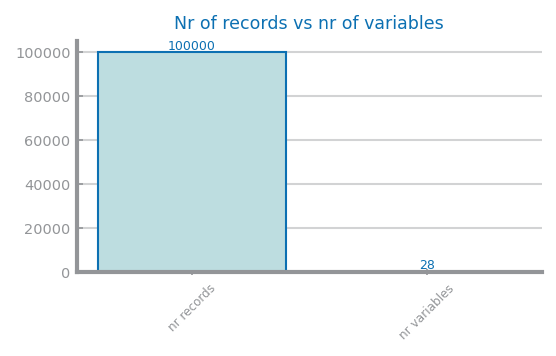

In [2]:
figure(figsize=(4, 2))

values: dict[str, int] = {"nr records": df.shape[0], "nr variables": df.shape[1]}

plot_bar_chart(list(values.keys()), list(values.values()), title="Nr of records vs nr of variables")
savefig(f"images/{file_tag}_records_variables.png", bbox_inches = "tight")
show()

In [3]:
# description
df.describe(include="all")

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,CreditMix,OutstandingDebt,CreditUtilizationRatio,Credit_History_Age,Payment_of_Min_Amount,TotalEMIpermonth,Amountinvestedmonthly,Payment_Behaviour,MonthlyBalance,Credit_Score
count,100000,100000,100000,90015,100000,94428,92938,1.000000e+05,84998.000000,100000.000000,...,79805,100000.000000,100000.000000,90970,100000,100000.000000,95521.000000,92400,9.880000e+04,100000
unique,100000,12500,8,10139,1788,12500,15,NaN,NaN,NaN,...,3,NaN,NaN,404,3,NaN,NaN,6,NaN,2
top,0x1602,CUS_0xd40,January,Langep,38,078-73-5990,Lawyer,NaN,NaN,NaN,...,Standard,NaN,NaN,15 Years and 11 Months,Yes,NaN,NaN,Low_spent_Small_value_payments,NaN,Good
freq,1,8,12500,44,2833,8,6575,NaN,NaN,NaN,...,36479,NaN,NaN,446,52326,NaN,NaN,25513,NaN,71002
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.764157e+05,4194.170850,17.091280,...,NaN,1426.220376,32.285173,NaN,NaN,1403.118217,637.412998,NaN,-3.036434e+22,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.429618e+06,3183.686167,117.404834,...,NaN,1155.129026,5.116875,NaN,NaN,8306.041270,2043.319327,NaN,3.181292e+24,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.005930e+03,303.645417,-1.000000,...,NaN,0.230000,20.000000,NaN,NaN,0.000000,0.000000,NaN,-3.333330e+26,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.945750e+04,1625.568229,3.000000,...,NaN,566.072500,28.052567,NaN,NaN,30.306660,74.534002,NaN,2.700922e+02,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.757861e+04,3093.745000,6.000000,...,NaN,1166.155000,32.305784,NaN,NaN,69.249473,135.925681,NaN,3.367192e+02,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.279092e+04,5957.448333,7.000000,...,NaN,1945.962500,36.496663,NaN,NaN,161.224249,265.731733,NaN,4.702202e+02,NaN


### SHAPE

In [4]:
# shape (Nr records x Nr variables)

print("Nr of records: ", len(df))
print("Dimensionality: ", df.shape)

Nr of records:  100000
Dimensionality:  (100000, 28)


### VARIABLE TYPES

{'numeric': ['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'NumofLoan', 'Delay_from_due_date', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'OutstandingDebt', 'CreditUtilizationRatio', 'TotalEMIpermonth', 'Amountinvestedmonthly', 'MonthlyBalance'], 'binary': ['Credit_Score'], 'date': [], 'symbolic': ['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation', 'Type_of_Loan', 'CreditMix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour']}


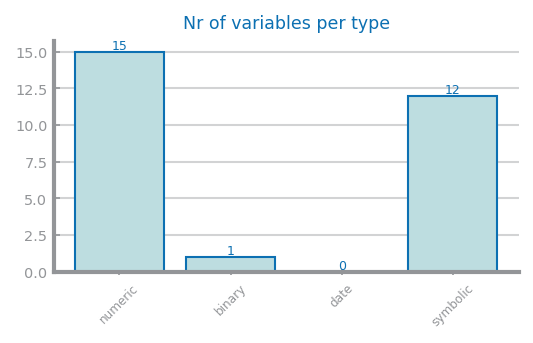

In [3]:
variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title="Nr of variables per type"
)
savefig(f"images/{file_tag}_variable_types.png", bbox_inches = "tight")
show()

In [6]:
symbolic: list[str] = variable_types["symbolic"]
df[symbolic] = df[symbolic].apply(lambda x: x.astype("category"))
df.dtypes

ID                        category
Customer_ID               category
Month                     category
Name                      category
Age                       category
SSN                       category
Occupation                category
Annual_Income              float64
Monthly_Inhand_Salary      float64
Num_Bank_Accounts            int64
Num_Credit_Card              int64
Interest_Rate                int64
NumofLoan                    int64
Type_of_Loan              category
Delay_from_due_date          int64
NumofDelayedPayment        float64
ChangedCreditLimit         float64
NumCreditInquiries         float64
CreditMix                 category
OutstandingDebt            float64
CreditUtilizationRatio     float64
Credit_History_Age        category
Payment_of_Min_Amount     category
TotalEMIpermonth           float64
Amountinvestedmonthly      float64
Payment_Behaviour         category
MonthlyBalance             float64
Credit_Score                object
dtype: object

### MISSING VALUES

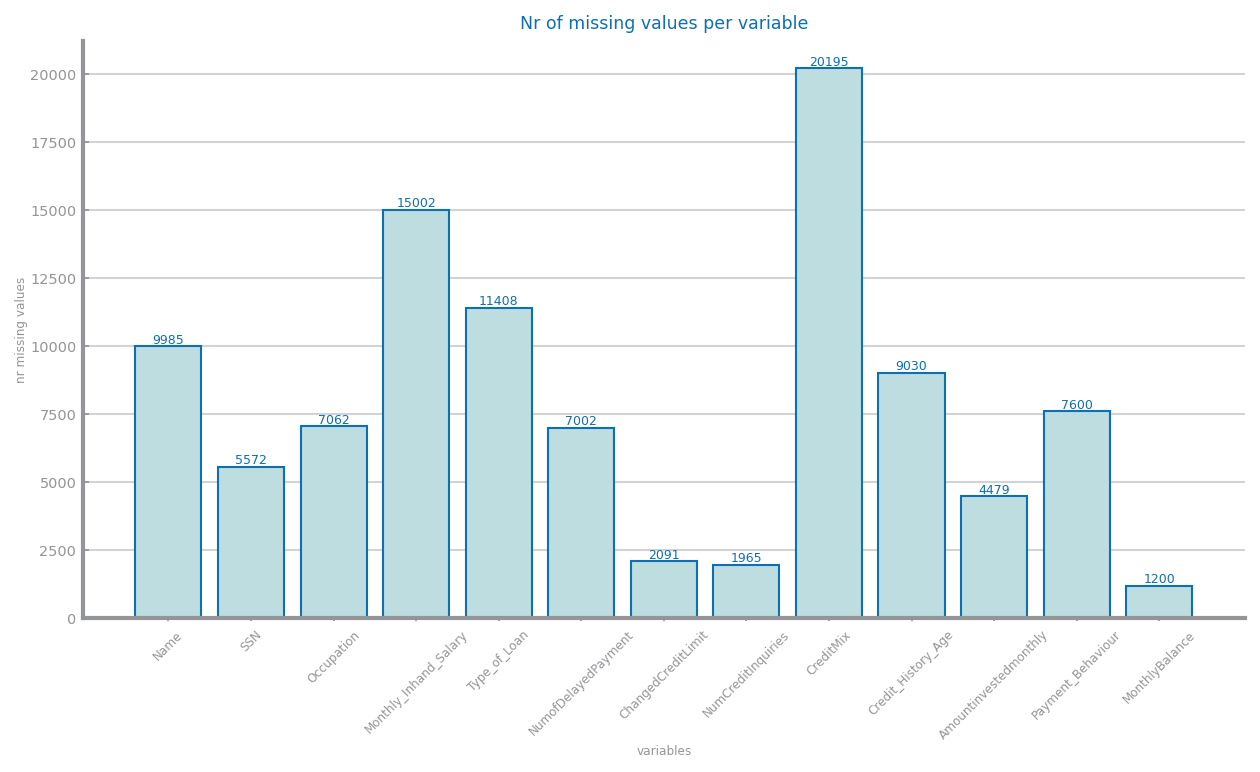

In [5]:
mv: dict[str, int] = {}
for var in df.columns:
    nr: int = df[var].isna().sum()
    if nr > 0:
        mv[var] = nr

figure(figsize = (10, 5))
plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
savefig(f"images/{file_tag}_mv.png", bbox_inches = "tight")
show()

## Data Granularity

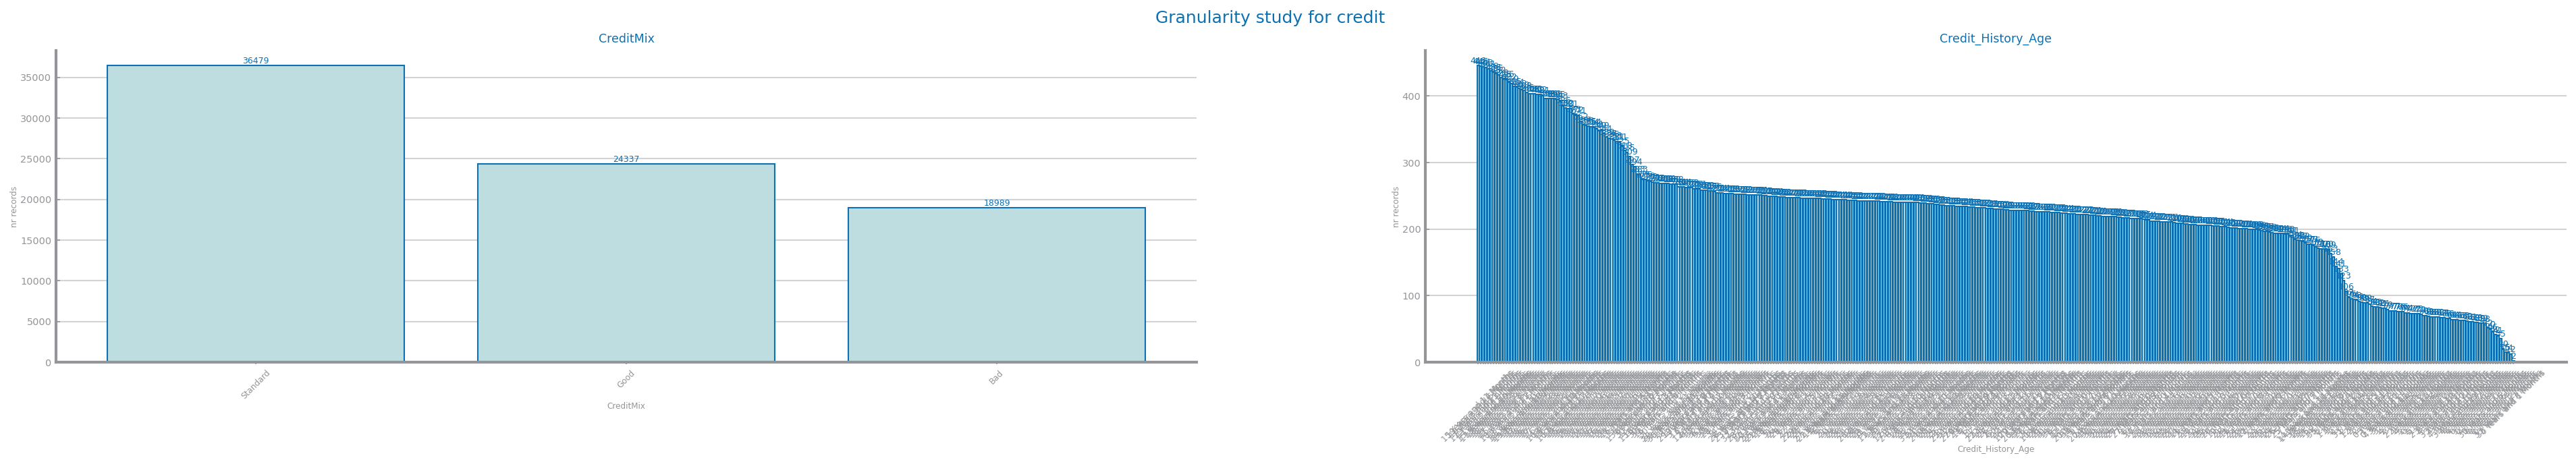

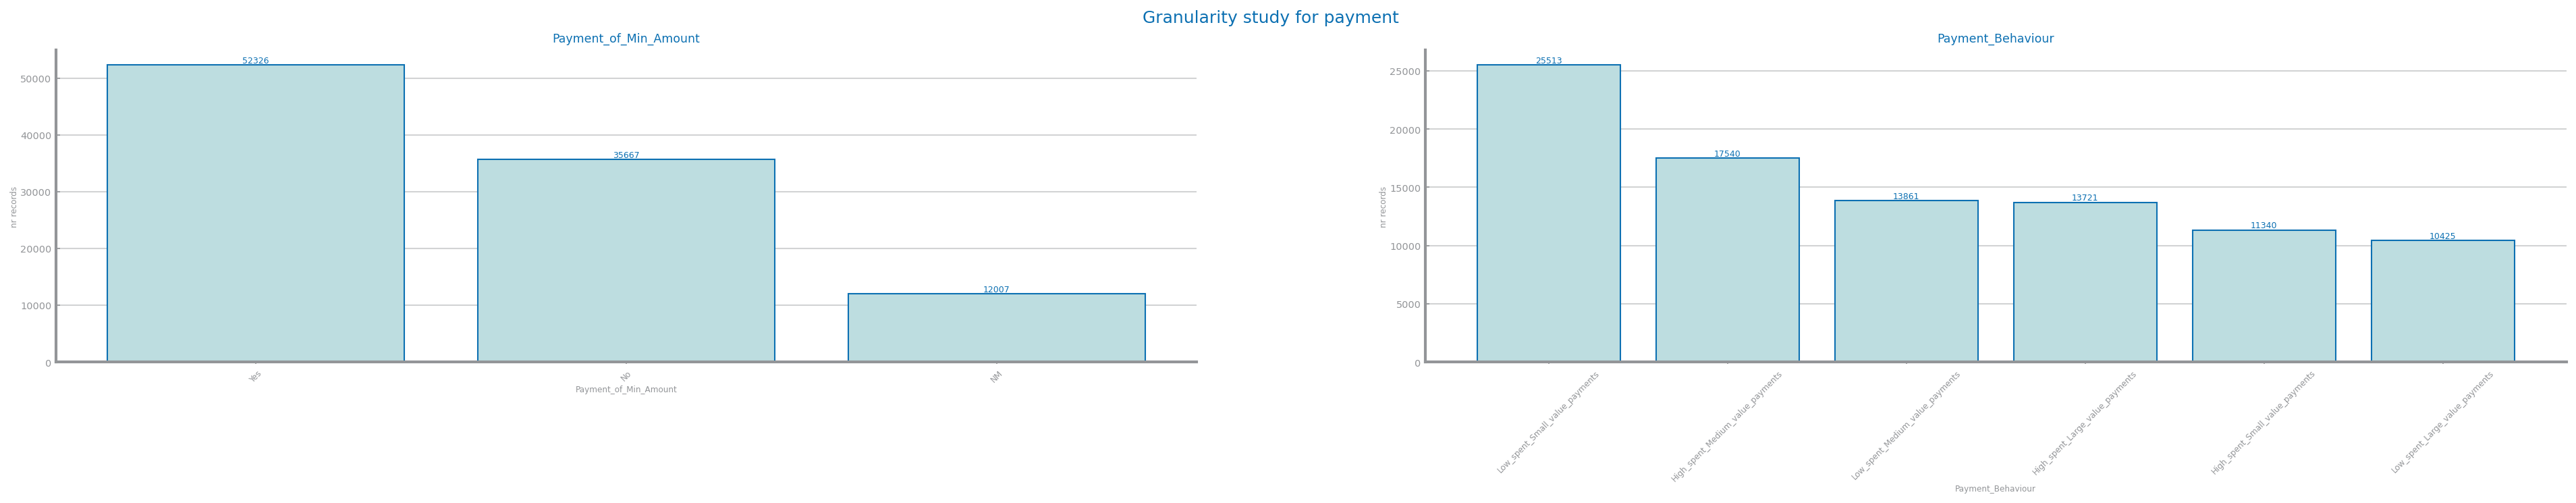

In [3]:
#data granularity -> symbolic variables

def analyse_property_granularity(
    data: DataFrame, property: str, vars: list[str]
) -> ndarray:
    cols: int = len(vars)
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, cols, figsize=(cols * HEIGHT * 4, HEIGHT), squeeze=False)
    fig.suptitle(f"Granularity study for {property}")
    for i in range(cols):
        counts: Series[int] = data[vars[i]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[0, i],
            title=vars[i],
            xlabel=vars[i],
            ylabel="nr records",
            percentage=False,
        )
    return axs

prop1 = "credit"
prop2 = "payment"
analyse_property_granularity(df, prop1, ["CreditMix", "Credit_History_Age"])
savefig(f"images/{file_tag}_granularity_{prop1}.png", bbox_inches = "tight")
analyse_property_granularity(df, prop2, ["Payment_of_Min_Amount", "Payment_Behaviour"])
savefig(f"images/{file_tag}_granularity_{prop2}.png", bbox_inches = "tight")
show()

## Data Distribution

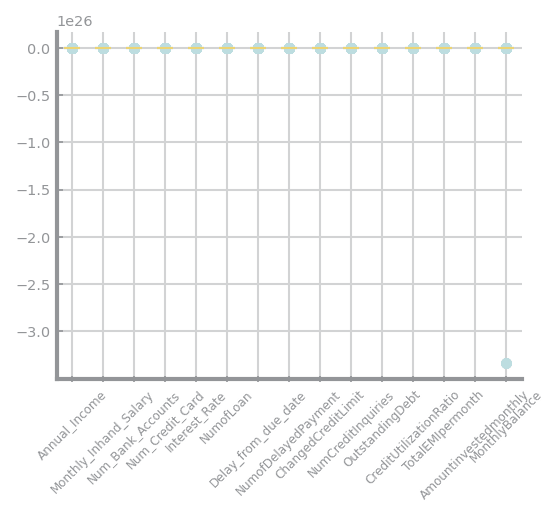

In [8]:
# global boxplot
variables_types: dict[str, list] = get_variable_types(df)
numeric: list[str] = variables_types["numeric"]
if [] != numeric:
    df[numeric].boxplot(rot=45)
    savefig(f"images/{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

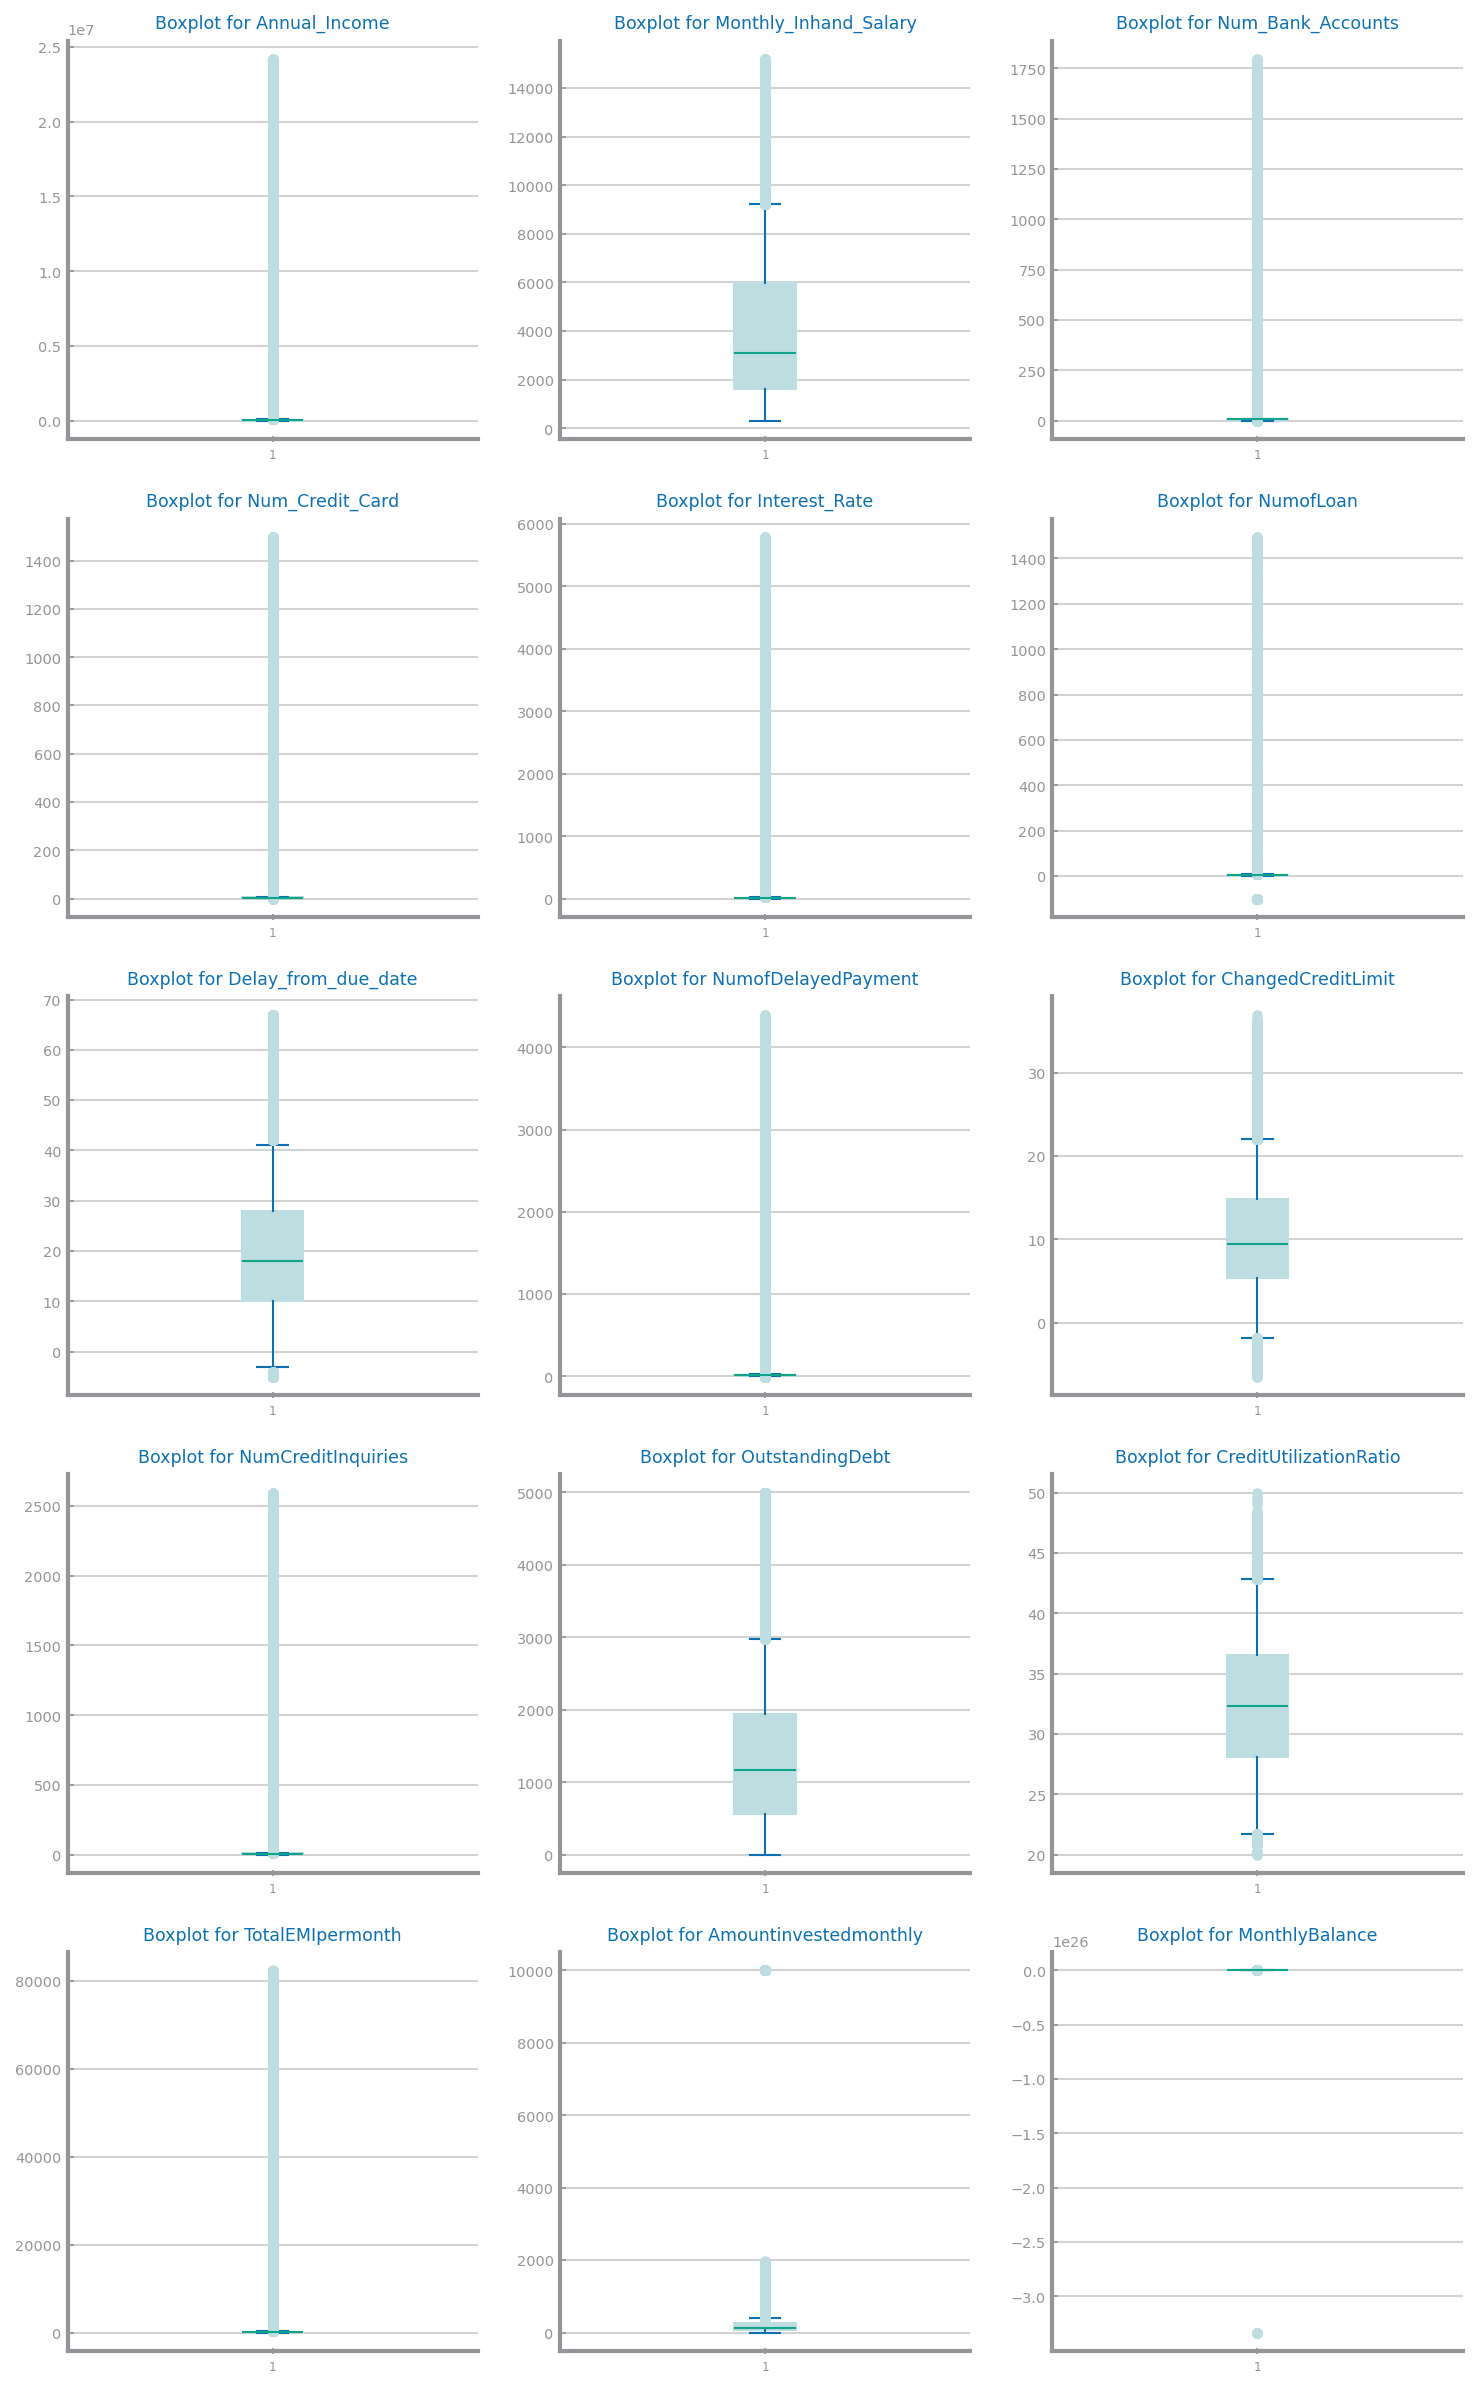

In [9]:
# boxplots for individual numeric vars
if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(df[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

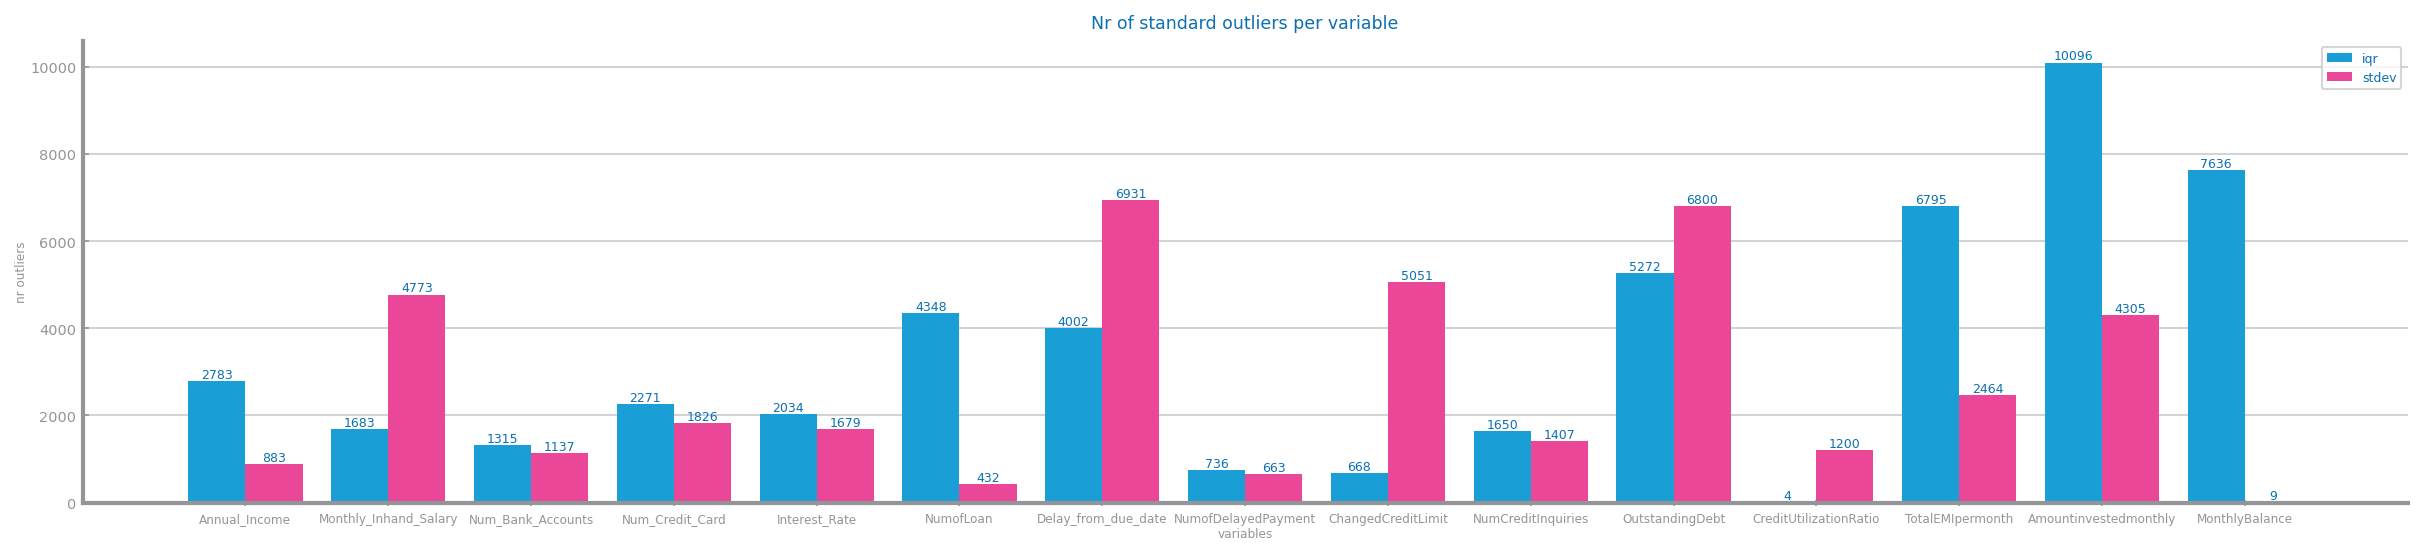

In [13]:
# standard outliers
NR_STDEV: int = 2
IQR_FACTOR: float = 1.5

def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom

def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}

if [] != numeric:
    outliers: dict[str, int] = count_outliers(df, numeric)
    figure(figsize=(20, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title="Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    
    savefig(f"images/{file_tag}_outliers_standard.png")
    show()
else:
    print("There are no numeric variables.")

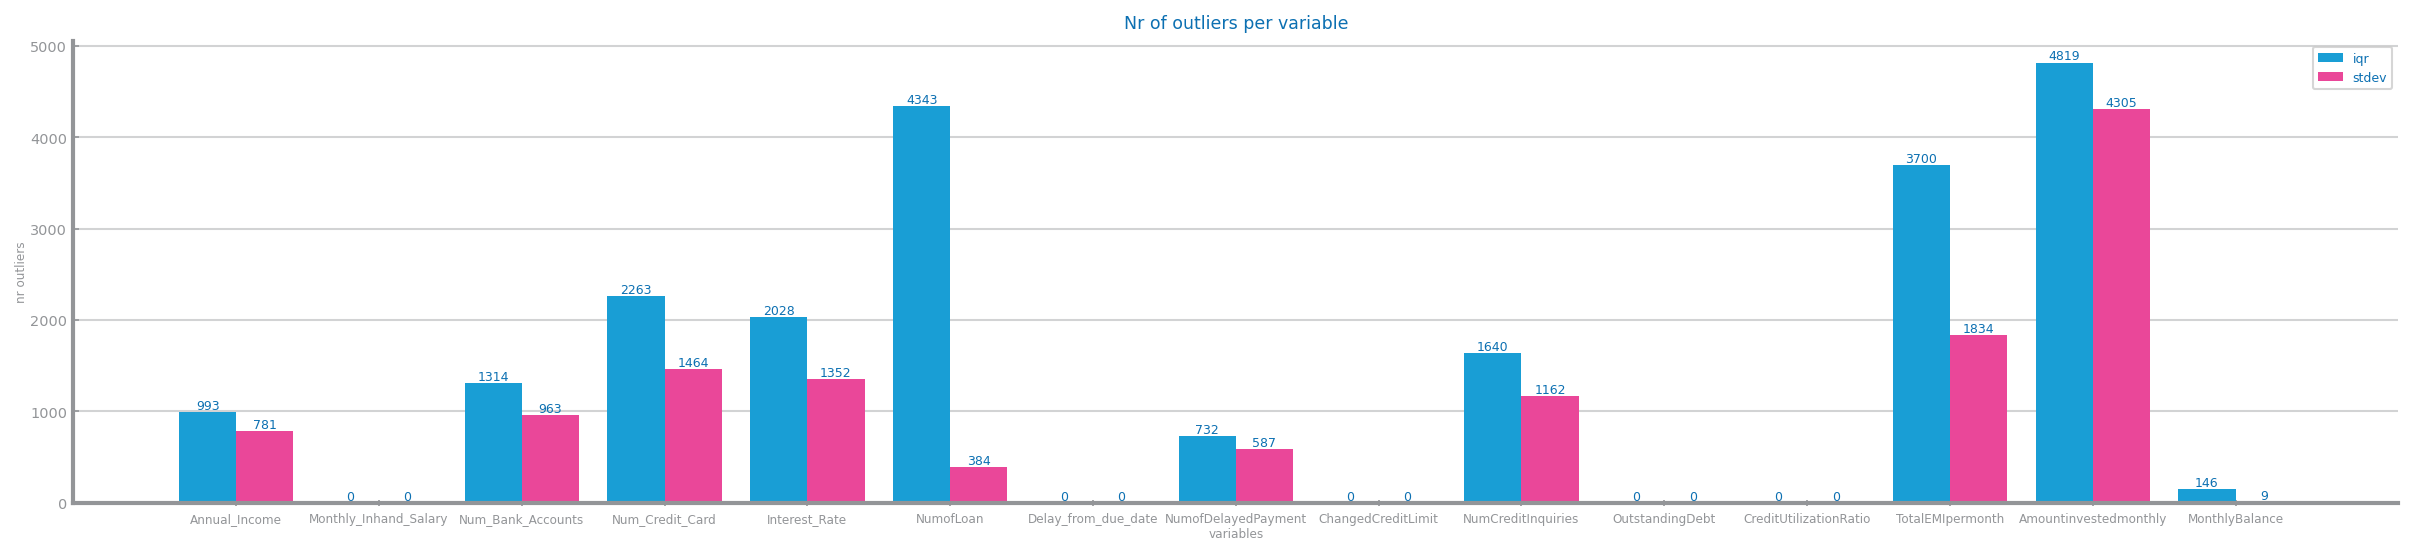

In [14]:
if [] != numeric:
    outliers: dict[str, int] = count_outliers(df, numeric, nrstdev=4, iqrfactor=4.5)
    figure(figsize=(20, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title="Nr of outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers.png")
    show()
else:
    print("There are no numeric variables.")

In [13]:
# histograms for numeric
'''
if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"Histogram for {numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(df[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_histograms_numeric.png")
    show()
else:
    print("There are no numeric variables.")
'''

'\nif [] != numeric:\n    fig, axs = subplots(\n        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False\n    )\n    i: int\n    j: int\n    i, j = 0, 0\n    for n in range(len(numeric)):\n        set_chart_labels(\n            axs[i, j],\n            title=f"Histogram for {numeric[n]}",\n            xlabel=numeric[n],\n            ylabel="nr records",\n        )\n        axs[i, j].hist(df[numeric[n]].dropna().values, "auto")\n        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)\n    savefig(f"images/{file_tag}_single_histograms_numeric.png")\n    show()\nelse:\n    print("There are no numeric variables.")\n'

In [14]:
# distributions for numeric

In [15]:
#histograms for symbolic
'''
variables_types: dict[str, list] = get_variable_types(df)
symbolic: list[str] = variables_types["symbolic"] + variables_types["binary"]
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(symbolic)):
        counts: Series = df[symbolic[n]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[i, j],
            title="Histogram for %s" % symbolic[n],
            xlabel=symbolic[n],
            ylabel="nr records",
            percentage=False,
        )
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_histograms_symbolic.png")
    show()
else:
    print("There are no symbolic variables.")
'''

'\nvariables_types: dict[str, list] = get_variable_types(df)\nsymbolic: list[str] = variables_types["symbolic"] + variables_types["binary"]\nif [] != symbolic:\n    rows, cols = define_grid(len(symbolic))\n    fig, axs = subplots(\n        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False\n    )\n    i, j = 0, 0\n    for n in range(len(symbolic)):\n        counts: Series = df[symbolic[n]].value_counts()\n        plot_bar_chart(\n            counts.index.to_list(),\n            counts.to_list(),\n            ax=axs[i, j],\n            title="Histogram for %s" % symbolic[n],\n            xlabel=symbolic[n],\n            ylabel="nr records",\n            percentage=False,\n        )\n        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)\n    savefig(f"images/{file_tag}_histograms_symbolic.png")\n    show()\nelse:\n    print("There are no symbolic variables.")\n'

Credit_Score
Good    71002
Poor    28998
Name: count, dtype: int64


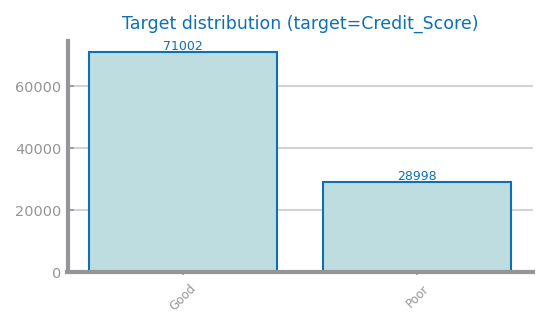

In [15]:
# class distribution
target = "Credit_Score"

values: Series = df[target].value_counts()
print(values)

figure(figsize=(4, 2))
plot_bar_chart(
    values.index.to_list(),
    values.to_list(),
    title=f"Target distribution (target={target})",
)
savefig(f"images/{file_tag}_class_distribution.png", bbox_inches = "tight")
show()

## Data Sparsity 

In [17]:
# scatter-plots (all x all - including class)

In [ ]:
# correlation (all x all - including class)
def dummify(df: DataFrame, vars_to_dummify: list[str]) -> DataFrame:
    other_vars: list[str] = [c for c in df.columns if not c in vars_to_dummify]

    enc = OneHotEncoder(
        handle_unknown="ignore", sparse_output=False, dtype="bool", drop="if_binary"
    )
    trans: ndarray = enc.fit_transform(df[vars_to_dummify])

    new_vars: ndarray = enc.get_feature_names_out(vars_to_dummify)
    dummy = DataFrame(trans, columns=new_vars, index=df.index)

    final_df: DataFrame = concat([df[other_vars], dummy], axis=1)
    return final_df

variables_types: dict[str, list] = get_variable_types(df)
symbolic: list[str] = variables_types["symbolic"] + variables_types["binary"]

df2: DataFrame = dummify(df, symbolic)

variables_types2: dict[str, list] = get_variable_types(df2)
numeric2: list[str] = variables_types2["numeric"]
symbolic2: list[str] = variables_types2["symbolic"] + variables_types2["binary"]
all_vars = numeric2 + symbolic2

corr_mtx: DataFrame = df2[all_vars].corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=all_vars,
    yticklabels=all_vars,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)
savefig(f"images/{file_tag}_correlation_analysis.png")
show()